# SCGEN:  Perturbation Prediction

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scgen[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/scgen@$branch#egg=scgen[tutorials]

In [2]:
import logging
import scanpy as sc
import scgen

In [3]:
#!pip install git+https://github.com/theislab/scgen.git@refs/pull/104/head

In [4]:
import torch
print("torch:", torch.__version__)
import scanpy
print("scanpy:", scanpy.__version__)
import scgen
print("scgen:", scgen.__version__)
import numpy
print("numpy:", numpy.__version__)
import scvi
print("scvi-tools:", scvi.__version__)

torch: 2.9.0+cu128
scanpy: 1.11.5
scgen: 2.1.1
numpy: 2.3.4
scvi-tools: 1.4.0.post1


/tmp/ipykernel_1780918/2572075443.py:4: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('scanpy')` instead
  print("scanpy:", scanpy.__version__)


### Loading Train Data

In [5]:
train = sc.read("./tests/data/train_kang.h5ad",
                backup_url='https://drive.google.com/uc?id=1r87vhoLLq6PXAYdmyyd89zG90eJOFYLk')

/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  return AnnData(**{
/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/anndata/_io/h5ad.py:266: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  return AnnData(**{


Let's remove stimulated CD4T cells from both the training set. This is just for the sake of this notebook, in practice, you do not need to do this step, just pass the train data

In [6]:
train_new = train[~((train.obs["cell_type"] == "CD4T") &
                    (train.obs["condition"] == "stimulated"))]

### Preprocessing Data

In [7]:
train_new = train_new.copy()

In [8]:
scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")

## Creating and Saving the model¶

In [9]:
model = scgen.SCGEN(train_new)
model.save("../saved_models/model_perturbation_prediction.pt", overwrite=True)

## Training the Model

In [24]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [MIG-GPU-44754d39-c195-2968-2c5e-1704c007e215/3/0;]
/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 30 module(s) in eval mode at the start of training. This may

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


### Latent Space

In [25]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=train_new.obs.copy())

/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:577: UserWarning: You’re trying to run this on 100 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  x = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)


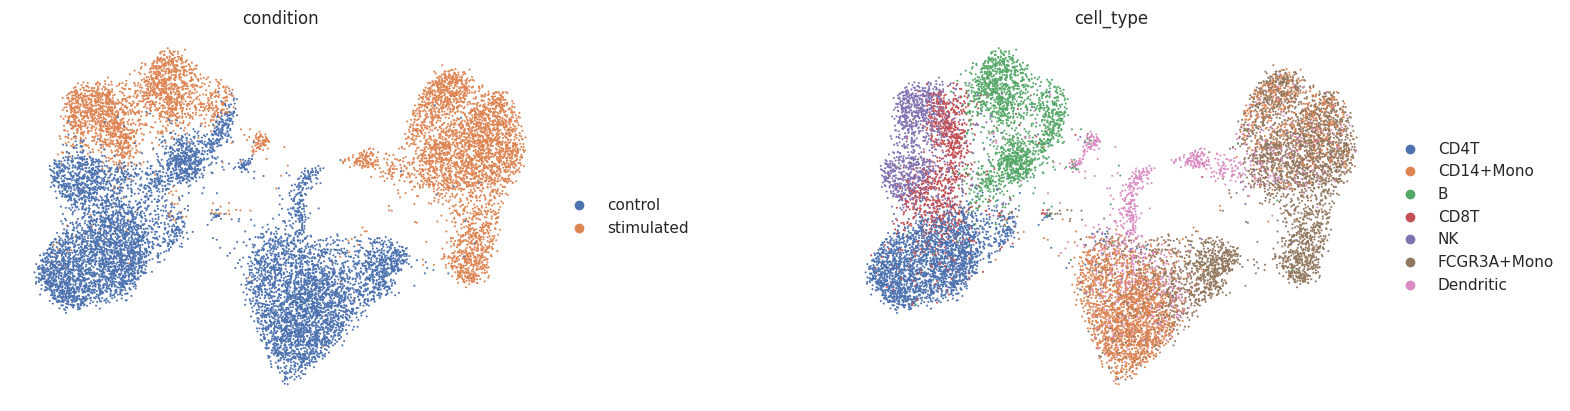

In [26]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)
sc.pl.umap(latent_adata, color=['condition', 'cell_type'], wspace=0.4, frameon=False,
           save='latentspace_batch32_klw000005_z100__100e.pdf')

## Prediction

After training the model you can pass the adata of the cells you want to perturb. Here we pass unperturbed CD4T cells


Here the 'adata' contains the cells that you want estimate the perturbation based on them. we set "ctrl" to our control labels and "stim" to our stimulated labels. If you apply it in another context just set "ctrl" :"your_control_label" and "stim":"your_stimulated_label". the returned value is a numpy matrix of our predicted cells and the second one is the difference vector between our conditions which might become useful later.

In [27]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key='stimulated',
    celltype_to_predict='CD4T'
)
pred.obs['condition'] = 'pred'

/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/anndata/_core/anndata.py:1796: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In the previous block, the difference between conditions is by default computed using all cells (obs_key="all"). However, some times you might have a rough idea that which groups (e.g. cell types) are close to your cell type of interest. This might give you more accurate predictions. For example, we can restrict the delta computation only to CD8T and NK cells. We provide dictionary in form of obs_key={"cell_type": ["CD8T", "NK"]} which is telling the model to look at "cell_type" labels in adata (here: train_new) and only compute the delta vector based on "CD8T" and "NK" cells :

pred, delta = scg.predict(adata=train_new, adata_to_predict=unperturbed_cd4t, conditions={"ctrl": "control", "stim": "stimulated"}, cell_type_key="cell_type", condition_key="condition", obs_key={"cell_type": ["CD8T", "NK"]})`

## Evaluation of the predcition¶


#### Extracting both control and real stimulated CD4T cells from our dataset

In [28]:
ctrl_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'control'))]
stim_adata = train[((train.obs['cell_type'] == 'CD4T') & (train.obs['condition'] == 'stimulated'))]

Merging predicted cells with real ones

In [29]:
eval_adata = ctrl_adata.concatenate(stim_adata, pred)

/tmp/ipykernel_1780918/794437606.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  eval_adata = ctrl_adata.concatenate(stim_adata, pred)


### Embedding all real and predicted cells in one PCA plot¶

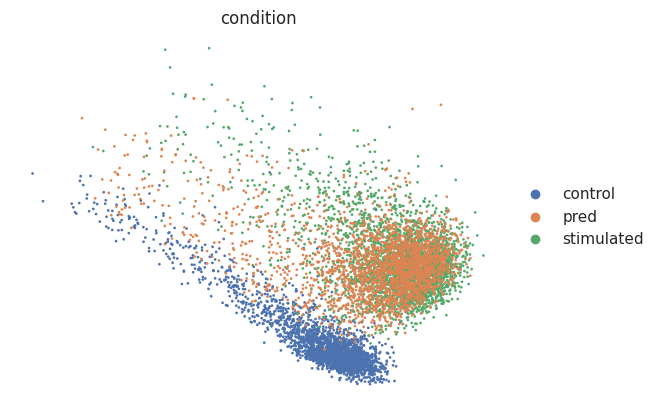

In [30]:
sc.tl.pca(eval_adata)
sc.pl.pca(eval_adata, color="condition", frameon=False,
           save='pred_stim_b32_klw000005_z100__100e.pdf')

## Mean correlation plot¶

You can also visualize your mean gene expression of your predicted cells vs control cells while highlighting your genes of interest (here top 10 differentially expressed genes)

In [31]:
CD4T = train[train.obs["cell_type"] =="CD4T"]

In [32]:
sc.tl.rank_genes_groups(CD4T, groupby="condition", method="wilcoxon")
diff_genes = CD4T.uns["rank_genes_groups"]["names"]["stimulated"]
print(diff_genes)

/home/c22200541/miniconda3/envs/scgen/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


['ISG15' 'IFI6' 'ISG20' ... 'FTL' 'RGCC' 'FTH1']


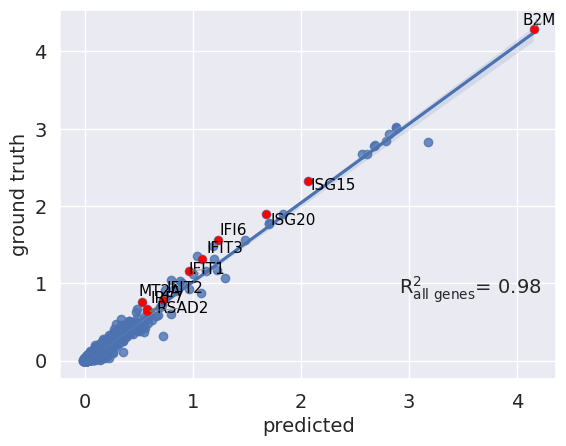

In [33]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    labels={"x": "predicted", "y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

You can also pass a list of differentially epxressed genes to compute correlation based on them

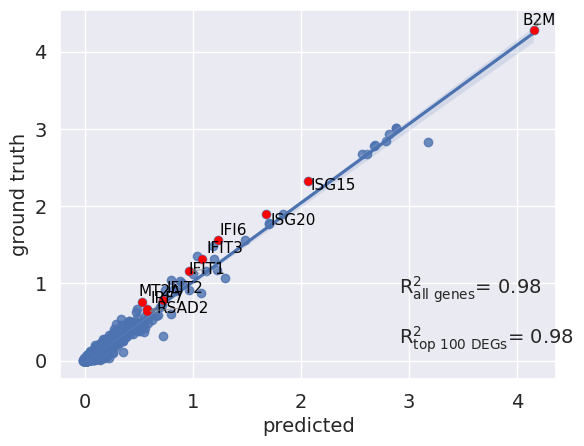

In [34]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={"x": "pred", "y": "stimulated"},
    gene_list=diff_genes[:10],
    top_100_genes= diff_genes,
    labels={"x": "predicted","y": "ground truth"},
    path_to_save="./reg_mean1.pdf",
    show=True,
    legend=False
)

### Violin plot for a specific gene¶


Let's go deeper and compare the distribution of "ISG15", the top DEG between stimulated and control CD4T cells between predcited and real cells

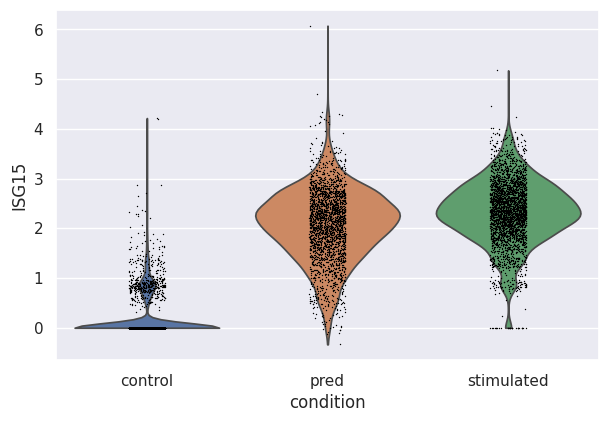

In [35]:
sc.pl.violin(eval_adata, keys="ISG15", groupby="condition")